### Introduction
#### create a machine learning model to help an insurance company understand which claims are worth rejecting and the claims which should be accepted for reimbursement. 

### Import the necessary packages

In [2]:
!pip install klib -q

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
import klib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re


from scipy.stats import skew, kurtosis
from prettytable import PrettyTable

### Import train and test dataset

In [13]:
train=pd.read_csv("../input/analytics-olympiad-2022/AnalyticsOlympiad2022Data/train.csv")
test=pd.read_csv("../input/analytics-olympiad-2022/AnalyticsOlympiad2022Data/test.csv")

### Change column names in train and test dataset to lowercase

In [14]:
train=train.rename(columns={col:col.lower()   for col in train.columns.values})
test=test.rename(columns={col:col.lower()  for col in test.columns.values})

### Structure of the train and test dataset

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

#### The above information shows that there are 105000 data entries and 18 columns.

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   45000 non-null  int64  
 1   age                  45000 non-null  object 
 2   gender               45000 non-null  object 
 3   driving_experience   45000 non-null  object 
 4   education            45000 non-null  object 
 5   income               45000 non-null  object 
 6   credit_score         45000 non-null  float64
 7   vehicle_ownership    45000 non-null  float64
 8   vehicle_year         45000 non-null  object 
 9   married              45000 non-null  float64
 10  children             45000 non-null  float64
 11  postal_code          45000 non-null  int64  
 12  annual_mileage       45000 non-null  float64
 13  speeding_violations  45000 non-null  int64  
 14  duis                 45000 non-null  int64  
 15  past_accidents       45000 non-null 

#### The above information shows that there are 45000 data entries and 17 columns.

### Let's see is there any missing values in train and test dataset by column wise.

In [8]:
train.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
type_of_vehicle        0
dtype: int64

#### The above information shows that there are no missing values.

In [9]:
test.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
speeding_violations    0
duis                   0
past_accidents         0
type_of_vehicle        0
dtype: int64

### The above information shows that there are no missing values.

### Let's see the glimpse of train dataset

In [10]:
train.head(2)

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,speeding_violations,duis,past_accidents,outcome,type_of_vehicle
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack


### Let's create a function to display the catgeorical column level counts.

In [6]:
def count_plot(df,col,rot=None,switchax=None,size=(8,6),title=''):
    _=plt.figure(figsize=size)
    if switchax:
        _=sns.countplot(y=df[col],order=df[col].value_counts().index);
        _=plt.title(title,fontsize=25)
        _=plt.ylabel(col,fontsize=20)
        _=plt.yticks(fontsize=14,rotation=rot)   

    else:
        _=sns.countplot(x=df[col],order=df[col].value_counts().index);
        _=plt.title(title,fontsize=25)
        _=plt.xlabel(col,fontsize=20)
        _=plt.xticks(fontsize=14,rotation=rot)   

### Let's create a function to display the group by catgeorical column level counts.

In [7]:
def grp_count_plot(df,col,grp,rot=None,switchax=None,size=(10,8),title=''):
    _=plt.figure(figsize=size)
    if switchax:
        g=sns.countplot(y=df[col],hue=df[grp],order=df[col].value_counts().index );
        g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
        _=plt.title(title,fontsize=25)
        _=plt.ylabel(col.capitalize(),fontsize=20)
        _=plt.yticks(fontsize=14,rotation=rot)
    else:
        g=sns.countplot(x=df[col],hue=df[grp],order=df[col].value_counts().index );
        g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
        _=plt.title(title,fontsize=25)
        _=plt.xlabel(col.capitalize(),fontsize=20)
        _=plt.xticks(fontsize=14,rotation=rot)

 

### Let's create a function for box plot.

In [8]:
def box_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col])
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20,rotation=rot)
  _=plt.yticks(fontsize=14)

### Let's create a function for side by side plot(density and group-wise boxplot).

In [9]:
def side_by_side_plot(df,grp,valcol,rot=None):
    clr="Paired"
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    sns.kdeplot(x=df[valcol], hue=df[grp],ax=ax1,palette=clr)
    ax1.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax1.set_xlabel(valcol,fontsize=20)
    sns.boxplot(x=df[grp],y=df[valcol],ax=ax2,palette=clr)
    ax2.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax2.set_xlabel(grp,fontsize=20)
    ax2.tick_params(rotation=rot)

### Let's create a function for group by numerical summary.

In [10]:
def group_summary(df,groupcol,value):
    return df.groupby(groupcol)[value].describe().reset_index().sort_values('mean',ascending=False)

In [11]:
def group_by_perc(df,grp,target,sortby='percentage',sort=False):
    return df.groupby([grp,target])[target].agg({'count'}).reset_index().assign(percentage=lambda x:round(x['count']*100/x['count'].sum(),2)).sort_values(sortby,ascending=sort)

### Let's see the target column(outcome) distribution.

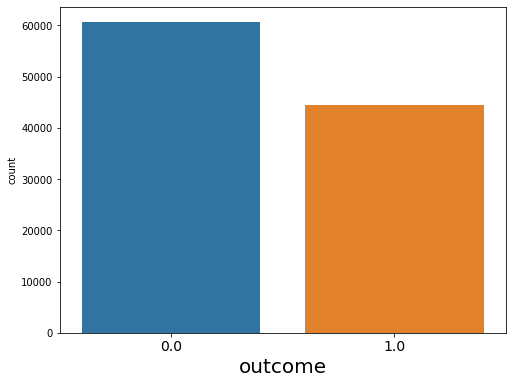

In [12]:
count_plot(train,'outcome')

In [14]:
train['outcome'].value_counts()

0.0    60622
1.0    44378
Name: outcome, dtype: int64

####  The above plot and summary explain that there is an imbalance between the classes.

### Let's see the age column distribution. The age column values are in binned numeric type.

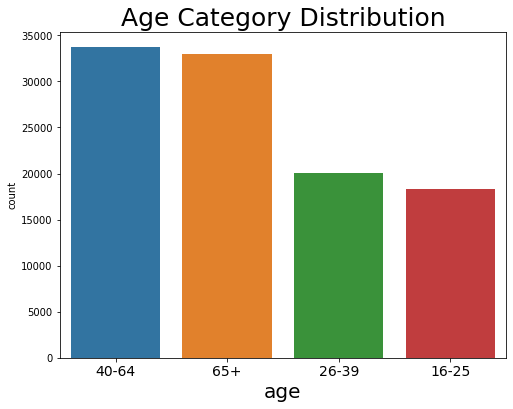

In [37]:
count_plot(train,'age',title='Age Category Distribution')

In [38]:
train['age'].value_counts()

40-64    33716
65+      32962
26-39    20018
16-25    18304
Name: age, dtype: int64

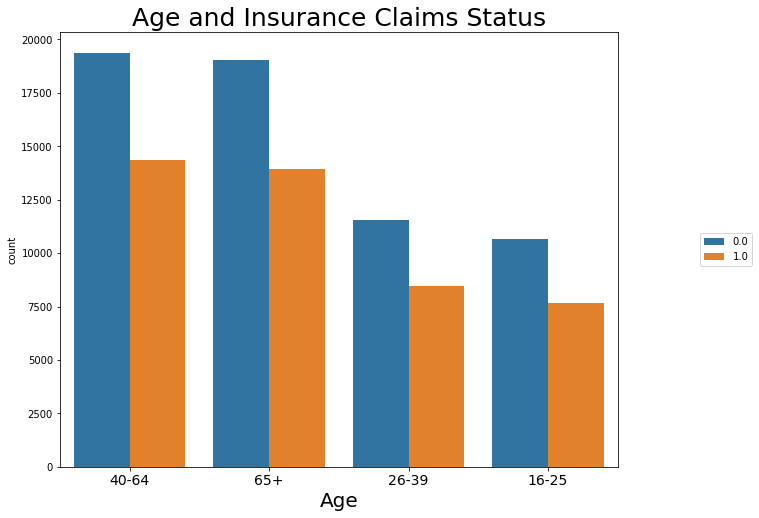

In [41]:
grp_count_plot(train,'age','outcome',title='Age and Insurance Claims Status')

In [42]:
group_by_perc(train,'age','outcome')

,age,outcome,count,percentage
4,40-64,0.0,19380,18.46
6,65+,0.0,19044,18.14
5,40-64,1.0,14336,13.65
7,65+,1.0,13918,13.26
2,26-39,0.0,11551,11.00
0,16-25,0.0,10647,10.14
3,26-39,1.0,8467,8.06
1,16-25,1.0,7657,7.29


#### The above plot and summary explain that the most of vehicle insurance claims are from the age category 40-64 & 65 more.


### Let's see the gender column distribution and see if are there any differences between the gender and insurance claim status.

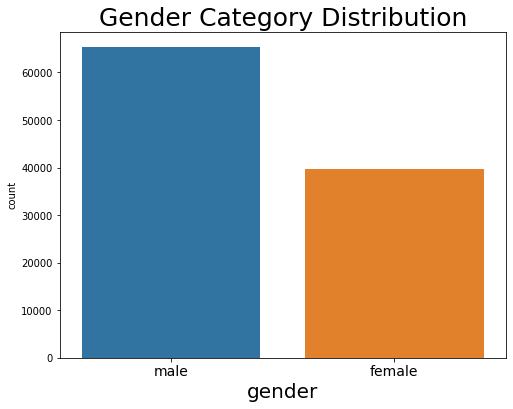

In [44]:
count_plot(train,'gender',title='Gender Category Distribution')

In [45]:
train['gender'].value_counts()

male      65317
female    39683
Name: gender, dtype: int64

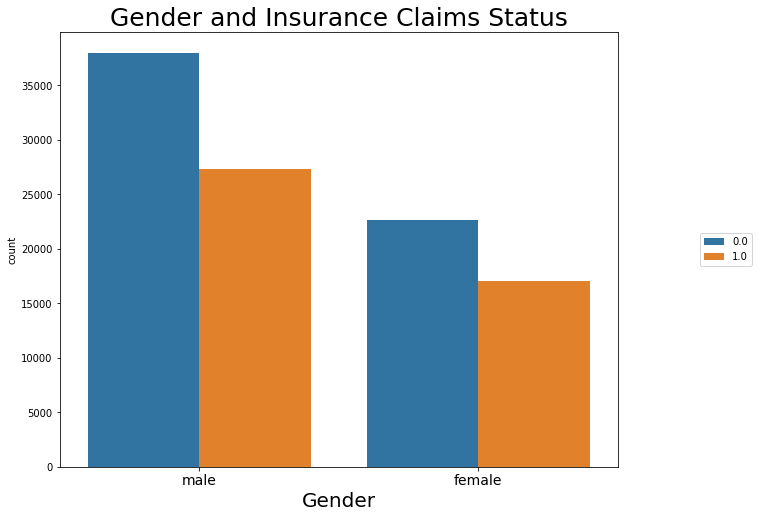

In [46]:
grp_count_plot(train,'gender','outcome',title='Gender and Insurance Claims Status')

In [47]:
group_by_perc(train,'gender','outcome')

,gender,outcome,count,percentage
2,male,0.0,38005,36.20
3,male,1.0,27312,26.01
0,female,0.0,22617,21.54
1,female,1.0,17066,16.25


#### The above plot and summary explain that most of the vehicle insurance claims are from males.

### Let's see customer's driving experience in year categories.

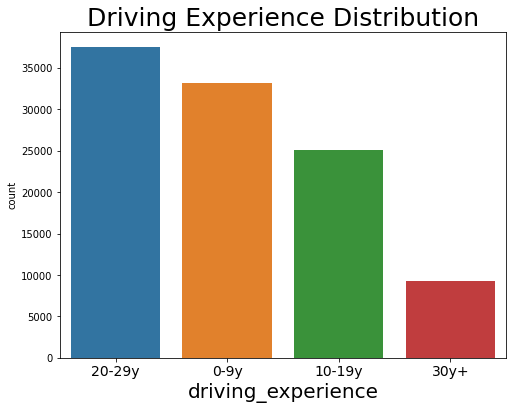

In [48]:
count_plot(train,'driving_experience',title='Driving Experience Distribution')

In [49]:
train['driving_experience'].value_counts()

20-29y    37493
0-9y      33111
10-19y    25101
30y+       9295
Name: driving_experience, dtype: int64

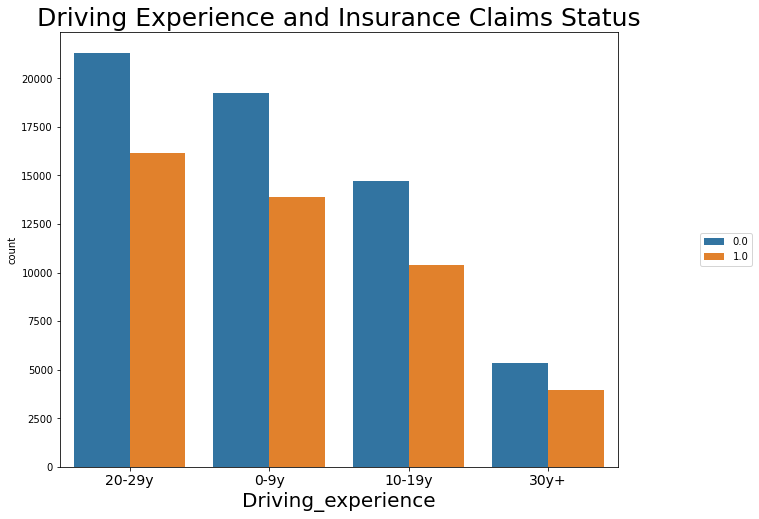

In [50]:
grp_count_plot(train,'driving_experience','outcome',title='Driving Experience and Insurance Claims Status')

In [53]:
group_by_perc(train,'driving_experience','outcome')

,driving_experience,outcome,count,percentage
4,20-29y,0.0,21324,20.31
0,0-9y,0.0,19231,18.32
5,20-29y,1.0,16169,15.40
2,10-19y,0.0,14731,14.03
1,0-9y,1.0,13880,13.22
3,10-19y,1.0,10370,9.88
6,30y+,0.0,5336,5.08
7,30y+,1.0,3959,3.77


#### The above plot and summary explain that most vehicle insurance claims are from customers who have 0-9 & 20-29 years of driving experience.

### Let's see the customer's education information and see the insurance claim status based on the education.

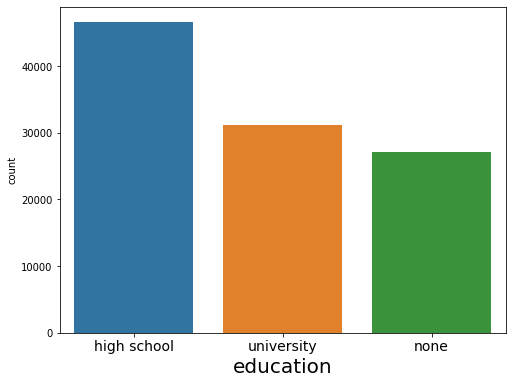

In [51]:
count_plot(train,'education')

In [52]:
train['education'].value_counts()

high school    46590
university     31220
none           27190
Name: education, dtype: int64

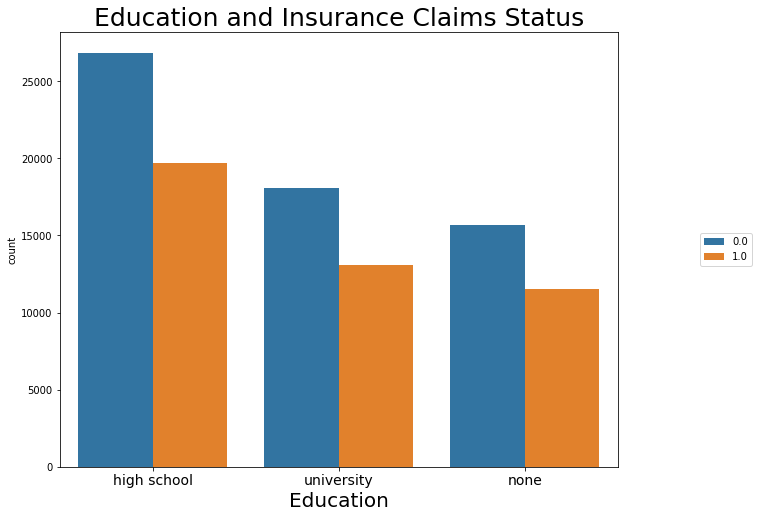

In [54]:
grp_count_plot(train,'education','outcome',title='Education and Insurance Claims Status')

In [59]:
group_by_perc(train,'education','outcome')

,education,outcome,count,percentage
0,high school,0.0,26859,25.58
1,high school,1.0,19731,18.79
4,university,0.0,18105,17.24
2,none,0.0,15658,14.91
5,university,1.0,13115,12.49
3,none,1.0,11532,10.98


#### The above plot and summary explain that most of the customers have high education and claimed most vehicle insurance.

### Let's see the income category distribution and see the differences between the income category and vehicle insurance claims status.

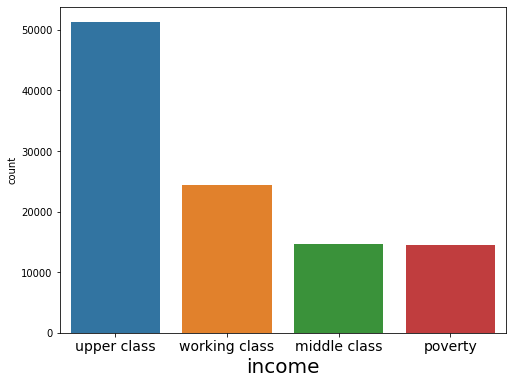

In [56]:
count_plot(train,'income')

In [57]:
train['income'].value_counts()

upper class      51271
working class    24454
middle class     14738
poverty          14537
Name: income, dtype: int64

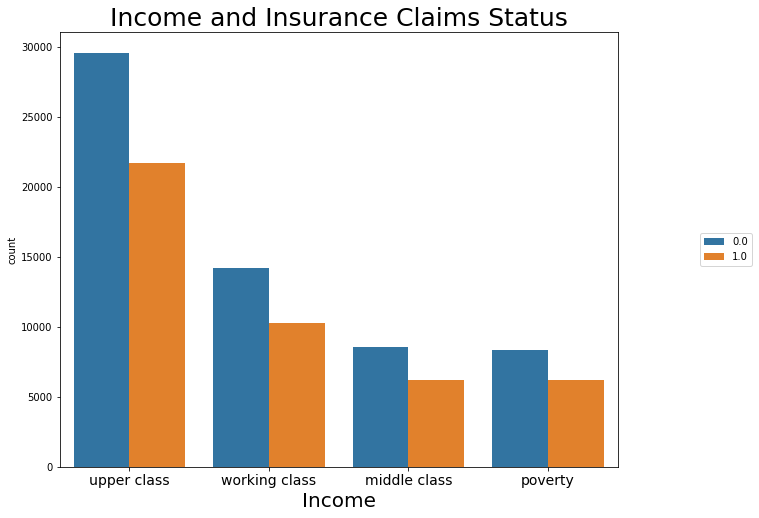

In [60]:
grp_count_plot(train,'income','outcome',title='Income and Insurance Claims Status')

In [61]:
group_by_perc(train,'income','outcome')

,income,outcome,count,percentage
4,upper class,0.0,29567,28.16
5,upper class,1.0,21704,20.67
6,working class,0.0,14178,13.50
7,working class,1.0,10276,9.79
0,middle class,0.0,8540,8.13
2,poverty,0.0,8337,7.94
1,middle class,1.0,6198,5.90
3,poverty,1.0,6200,5.90


#### The above plot and summary explain that the most of customers are from the upper class income category and they claimed more vehicle insurance.


### Let's see customer's credit score distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='credit_score', ylabel='Density'>

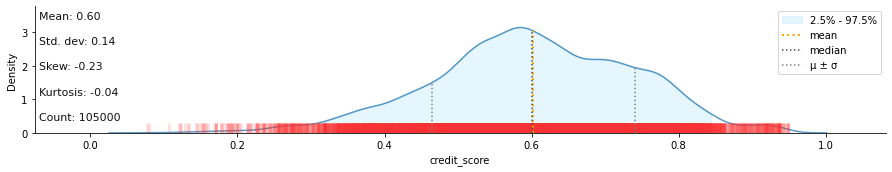

In [13]:
klib.dist_plot(train['credit_score'])

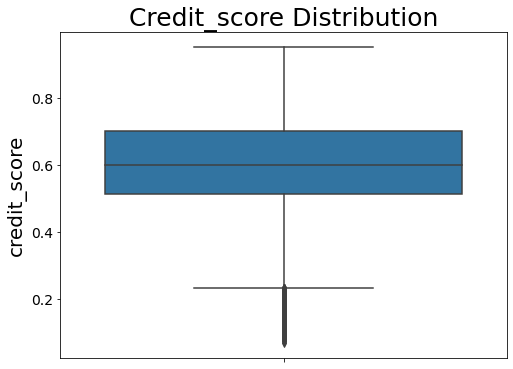

In [16]:
box_plot(train,'credit_score',rot=90)

In [17]:
train['credit_score'].describe()

count    105000.000000
mean          0.602173
std           0.138045
min           0.066880
25%           0.514876
50%           0.601112
75%           0.703216
max           0.954075
Name: credit_score, dtype: float64

#### The above histogram plot and summary explain that the customer's credit score is normally distributed.
#### The customers credit score ranges from 0.067 to 0.9541.
#### The average credit score is 0.6022.
#### The boxplot explains that there are outliers below the third quartile.


### Let's see is there are any differences between the credit score and vehicle insurance claim status.

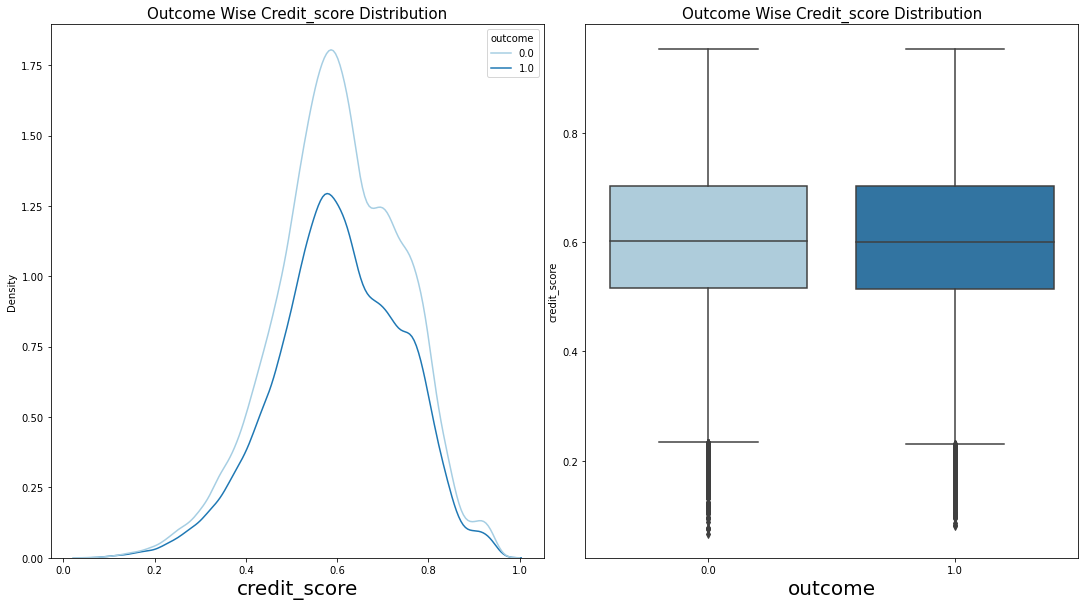

In [18]:
side_by_side_plot(train,'outcome','credit_score')

In [19]:
group_summary(train,'outcome','credit_score')

,outcome,count,mean,std,min,25%,50%,75%,max
0,0.0,60622.0,0.602535,0.137628,0.066880,0.515398,0.601315,0.703280,0.953780
1,1.0,44378.0,0.601678,0.138613,0.079844,0.514062,0.600735,0.703129,0.954075


#### The above boxplot explains that there are no significant differences between credit score and insurance claim status.

### Let's see the insurance claim status based on the vehicle ownership information.

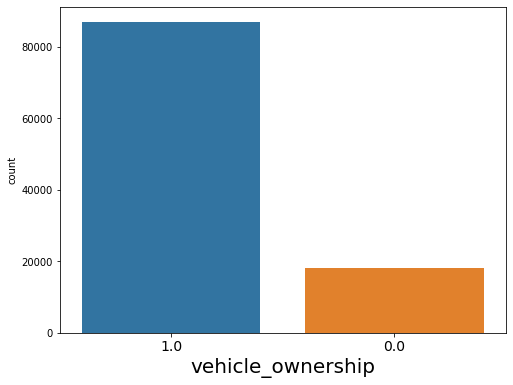

In [22]:
count_plot(train,'vehicle_ownership')

In [23]:
train['vehicle_ownership'].value_counts()

1.0    86839
0.0    18161
Name: vehicle_ownership, dtype: int64

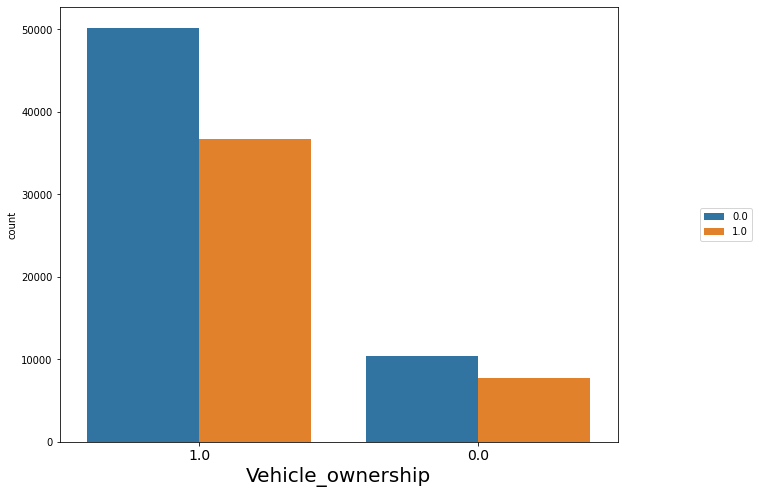

In [24]:
grp_count_plot(train,'vehicle_ownership','outcome')

In [25]:
group_by_perc(train,'vehicle_ownership','outcome')

,vehicle_ownership,outcome,count,percentage
2,1.0,0.0,50197,47.81
3,1.0,1.0,36642,34.90
0,0.0,0.0,10425,9.93
1,0.0,1.0,7736,7.37


#### The above plot and summary explain that most of the customers are having own vehicle and own vehicle customers are claiming most vehicle insurance.

### Let's see the differences between the vehicle's year of manufacturing and insurance claims.

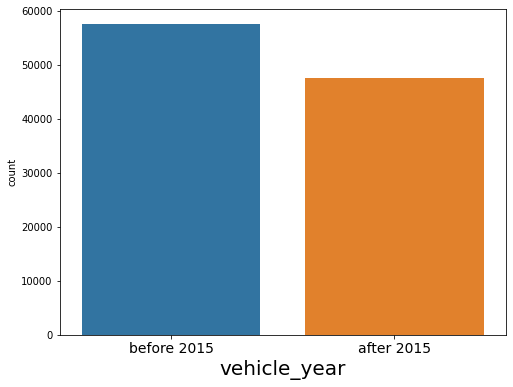

In [28]:
count_plot(train,'vehicle_year')

In [29]:
train['vehicle_year'].value_counts()

before 2015    57511
after 2015     47489
Name: vehicle_year, dtype: int64

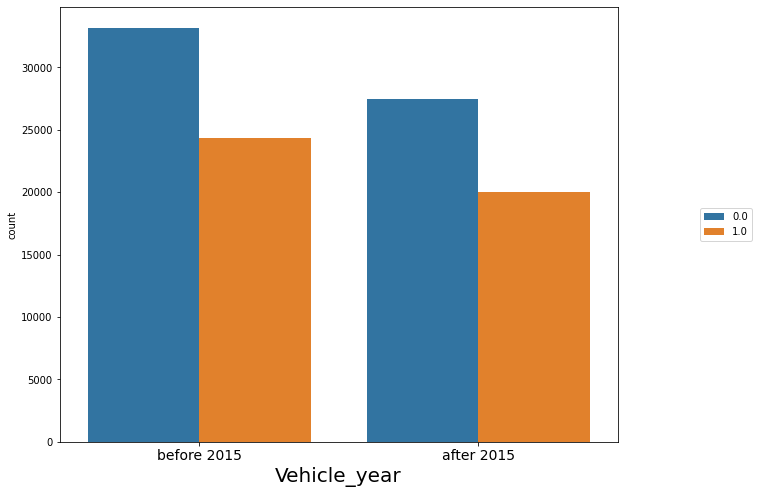

In [30]:
grp_count_plot(train,'vehicle_year','outcome')

In [31]:
group_by_perc(train,'vehicle_year','outcome')

,vehicle_year,outcome,count,percentage
2,before 2015,0.0,33182,31.60
0,after 2015,0.0,27440,26.13
3,before 2015,1.0,24329,23.17
1,after 2015,1.0,20049,19.09


#### The above plot and summary explain that most of the vehicles are manufactured before the year 2015 and claim most insurance.

### Let's see the insurance claim status based on the customer's marriage status.

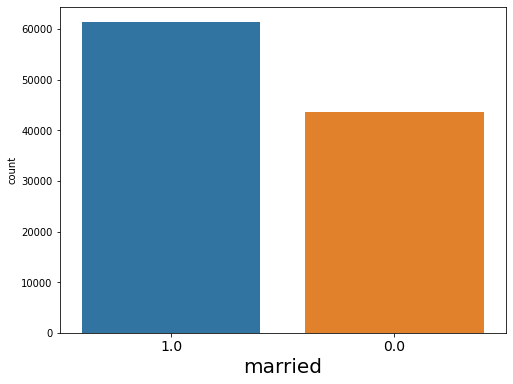

In [33]:
count_plot(train,'married')

In [34]:
train['married'].value_counts()

1.0    61335
0.0    43665
Name: married, dtype: int64

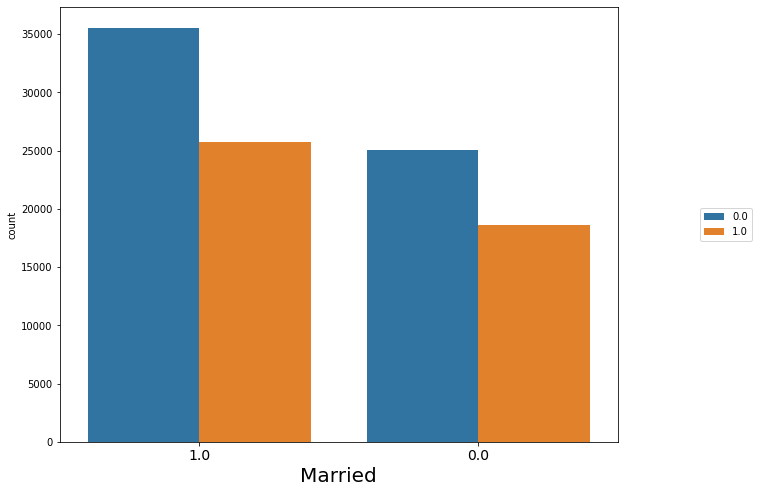

In [35]:
grp_count_plot(train,'married','outcome')

In [36]:
group_by_perc(train,'married','outcome')

,married,outcome,count,percentage
2,1.0,0.0,35566,33.87
3,1.0,1.0,25769,24.54
0,0.0,0.0,25056,23.86
1,0.0,1.0,18609,17.72


#### The above plot and summary explain that the most of customers are married.

### Let's see how many children customers have and see the differences in insurance claim status.

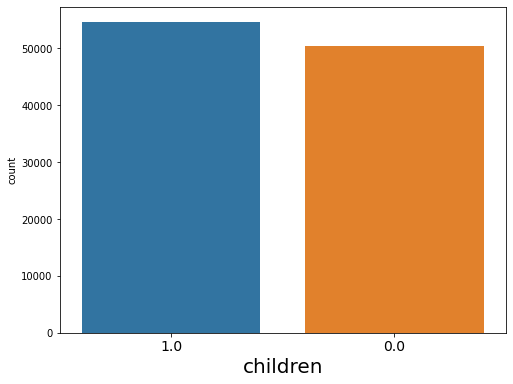

In [41]:
count_plot(train,'children')

In [42]:
train['children'].value_counts()

1.0    54600
0.0    50400
Name: children, dtype: int64

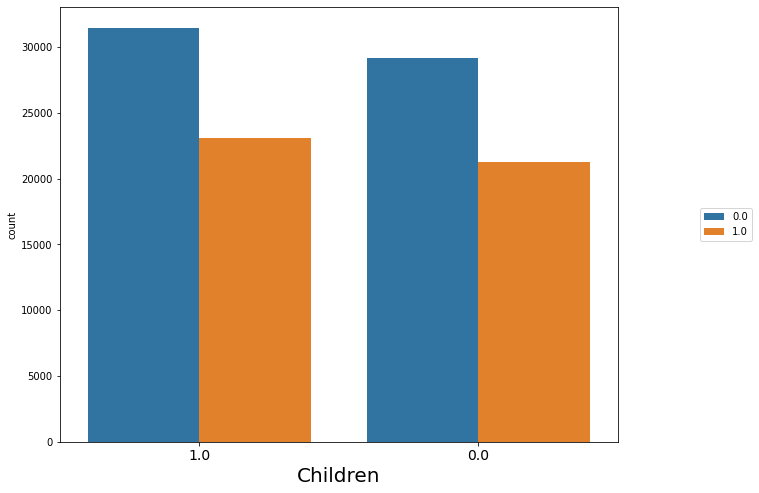

In [43]:
grp_count_plot(train,'children','outcome')

In [44]:
group_by_perc(train,'children','outcome')

,children,outcome,count,percentage
2,1.0,0.0,31475,29.98
0,0.0,0.0,29147,27.76
3,1.0,1.0,23125,22.02
1,0.0,1.0,21253,20.24


#### The above plot and summary explain that most customers have either one child or no child.

### Let's see the annual mileage of vehicles.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='annual_mileage', ylabel='Density'>

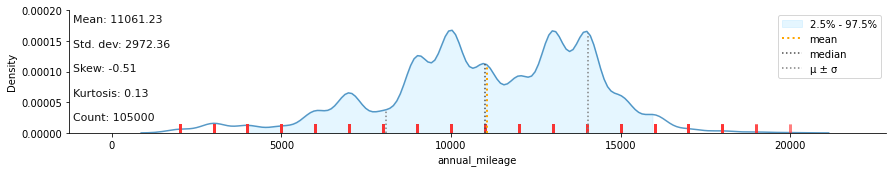

In [45]:
klib.dist_plot(train['annual_mileage'])

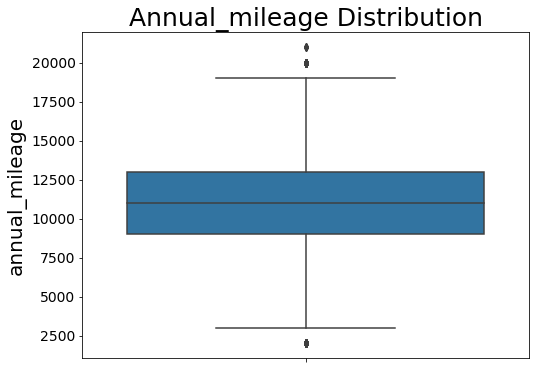

In [47]:
box_plot(train,'annual_mileage',rot=90)

In [48]:
train['annual_mileage'].describe()

count    105000.000000
mean      11061.228571
std        2972.355482
min        2000.000000
25%        9000.000000
50%       11000.000000
75%       13000.000000
max       21000.000000
Name: annual_mileage, dtype: float64

#### The above histogram plot and summary explain that the vehicle's annual mileage is normally distributed(but there is more than one mode).
#### The vehicle's annual mileage ranges from 2000 to 21000.
#### The average annual mileage is 11061.229.
#### The boxplot explains that there are outliers above the third quartile and below the first quartile.

### Let's see the type of vehicle and insurance claiming status.

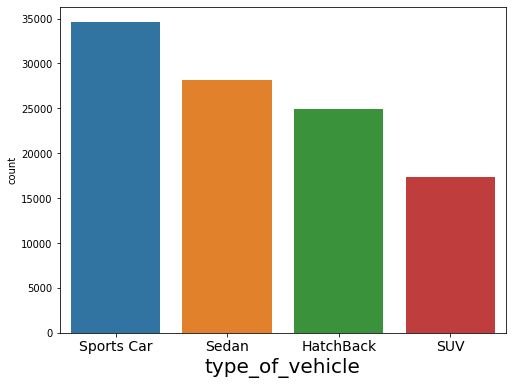

In [50]:
count_plot(train,'type_of_vehicle')

In [49]:
train['type_of_vehicle'].value_counts()

Sports Car    34592
Sedan         28120
HatchBack     24900
SUV           17388
Name: type_of_vehicle, dtype: int64

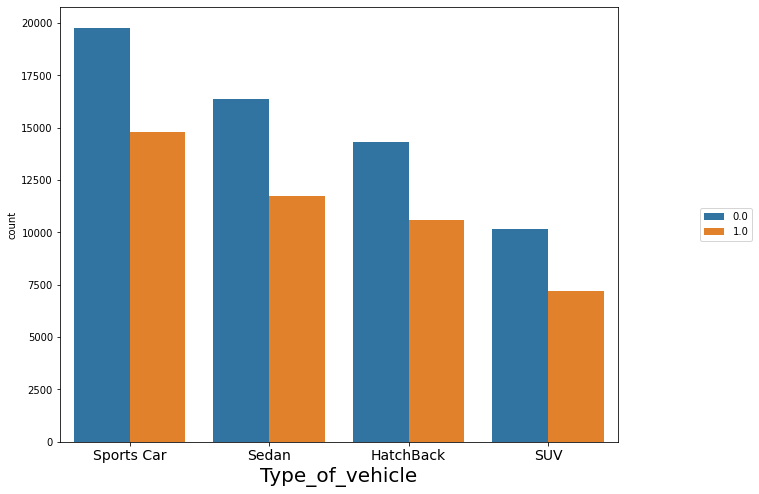

In [51]:
grp_count_plot(train,'type_of_vehicle','outcome')

In [52]:
group_by_perc(train,'type_of_vehicle','outcome')

,type_of_vehicle,outcome,count,percentage
6,Sports Car,0.0,19785,18.84
4,Sedan,0.0,16367,15.59
7,Sports Car,1.0,14807,14.10
0,HatchBack,0.0,14300,13.62
5,Sedan,1.0,11753,11.19
1,HatchBack,1.0,10600,10.10
2,SUV,0.0,10170,9.69
3,SUV,1.0,7218,6.87


#### The above plot and summary explain that most customers have sports and sedan cars.

### Let's see how many speed violations had done by customers and see the insurance claims based on the speed violation.

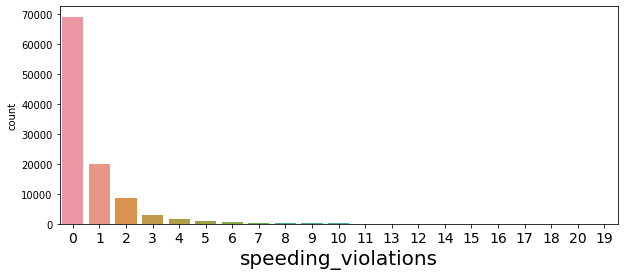

In [55]:
count_plot(train,'speeding_violations',size=(10,4))

In [56]:
train['speeding_violations'].value_counts()

0     69163
1     19867
2      8749
3      2990
4      1688
5       911
6       483
7       351
8       260
9       172
10      109
11       87
13       58
12       56
14       25
15       15
16        7
17        4
18        3
20        1
19        1
Name: speeding_violations, dtype: int64

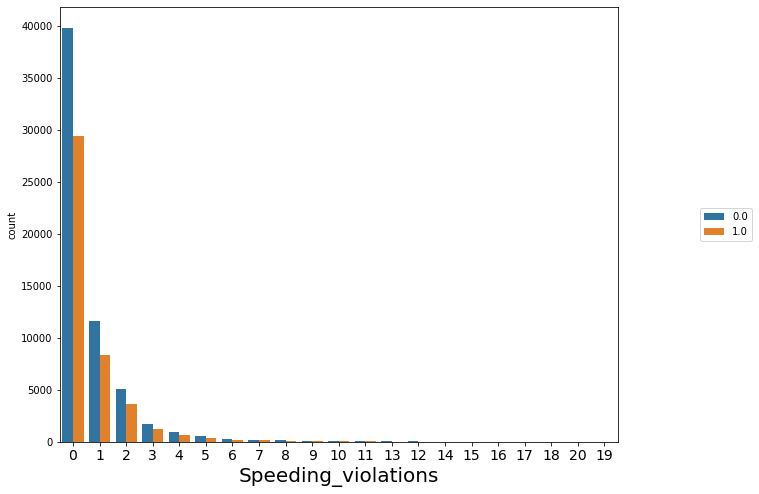

In [57]:
grp_count_plot(train,'speeding_violations','outcome')

In [15]:
group_by_perc(train,'speeding_violations','outcome')

,speeding_violations,outcome,count,percentage
0,0,0.0,39813,37.92
1,0,1.0,29350,27.95
2,1,0.0,11566,11.02
3,1,1.0,8301,7.91
4,2,0.0,5081,4.84
5,2,1.0,3668,3.49
6,3,0.0,1728,1.65
7,3,1.0,1262,1.20
8,4,0.0,990,0.94
9,4,1.0,698,0.66


#### The above plot and summary explain that most of the customers had not done any speed violations.

### Let's see whether customers have driven the vehicle after drinking(alcohol and other drugs) and see how it is affecting insurance claiming.

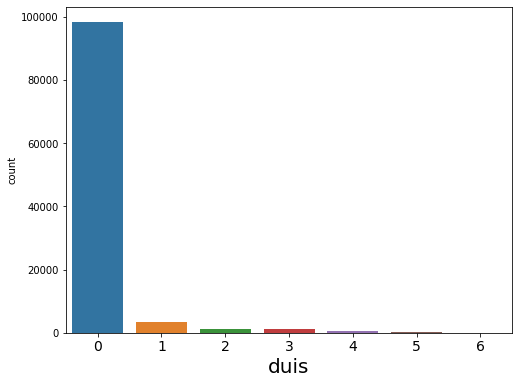

In [16]:
count_plot(train,'duis')

In [17]:
train['duis'].value_counts()

0    98246
1     3430
2     1219
3     1069
4      709
5      251
6       76
Name: duis, dtype: int64

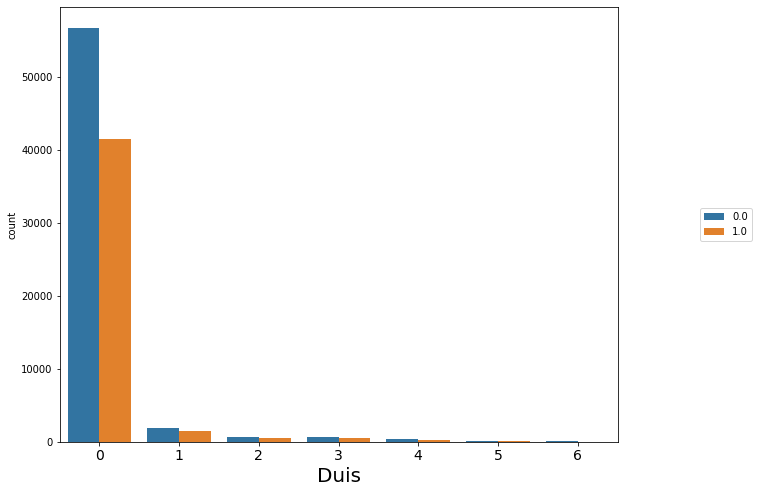

In [18]:
grp_count_plot(train,'duis','outcome')

In [19]:
group_by_perc(train,'duis','outcome')

,duis,outcome,count,percentage
0,0,0.0,56746,54.04
1,0,1.0,41500,39.52
2,1,0.0,1948,1.86
3,1,1.0,1482,1.41
4,2,0.0,717,0.68
6,3,0.0,612,0.58
5,2,1.0,502,0.48
7,3,1.0,457,0.44
8,4,0.0,407,0.39
9,4,1.0,302,0.29


#### The above plot and summary explain that most of the customers had not drunk while driving the vehicle.

### Let's see whether customers have any past accident records of their vehicle and see how it is affecting the insurance claiming status.

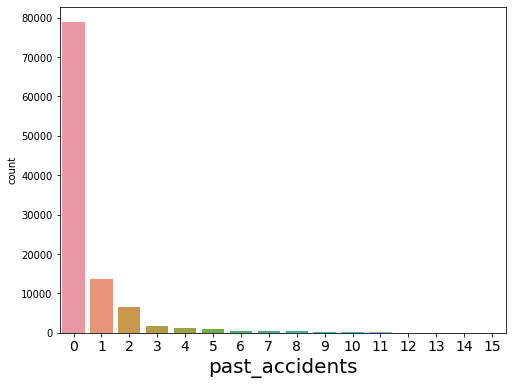

In [20]:
count_plot(train,'past_accidents')

In [21]:
train['past_accidents'].value_counts()

0     78853
1     13762
2      6454
3      1749
4      1317
5       906
6       534
7       413
8       340
9       236
10      157
11       92
12       75
13       50
14       38
15       24
Name: past_accidents, dtype: int64

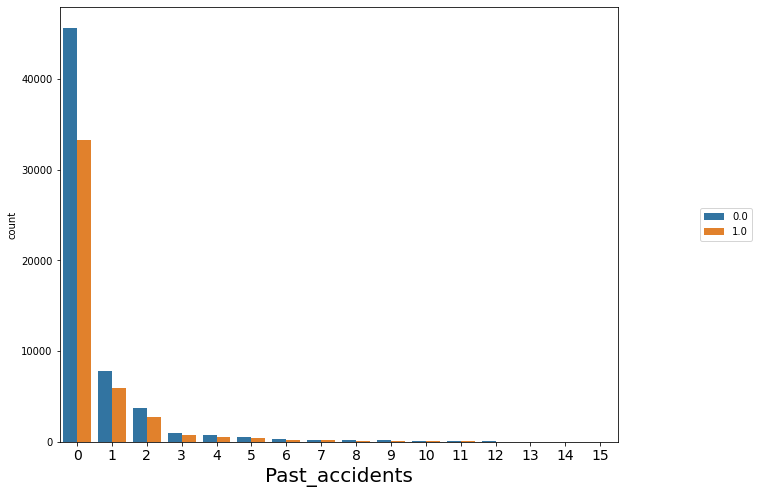

In [22]:
grp_count_plot(train,'past_accidents','outcome')

In [23]:
group_by_perc(train,'past_accidents','outcome')

,past_accidents,outcome,count,percentage
0,0,0.0,45645,43.47
1,0,1.0,33208,31.63
2,1,0.0,7823,7.45
3,1,1.0,5939,5.66
4,2,0.0,3680,3.50
5,2,1.0,2774,2.64
6,3,0.0,988,0.94
8,4,0.0,786,0.75
7,3,1.0,761,0.72
9,4,1.0,531,0.51


#### The above plot and summary explain that most of the customers had not had any accident records for their vehicles.

### Let's see credit score distribution by different categorical columns age, gender, driving_experience, education, income, vehicle_ownership, vehicle_year, married, children, speeding_violations, duis, past_accidents, outcome, type_of_vehicle.

<Figure size 1080x576 with 0 Axes>

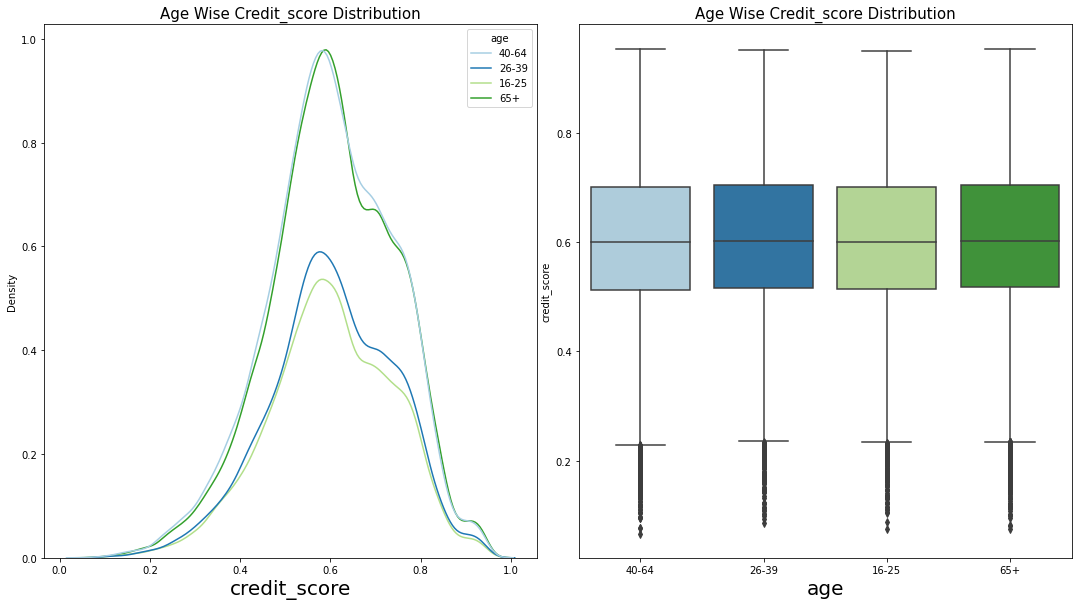

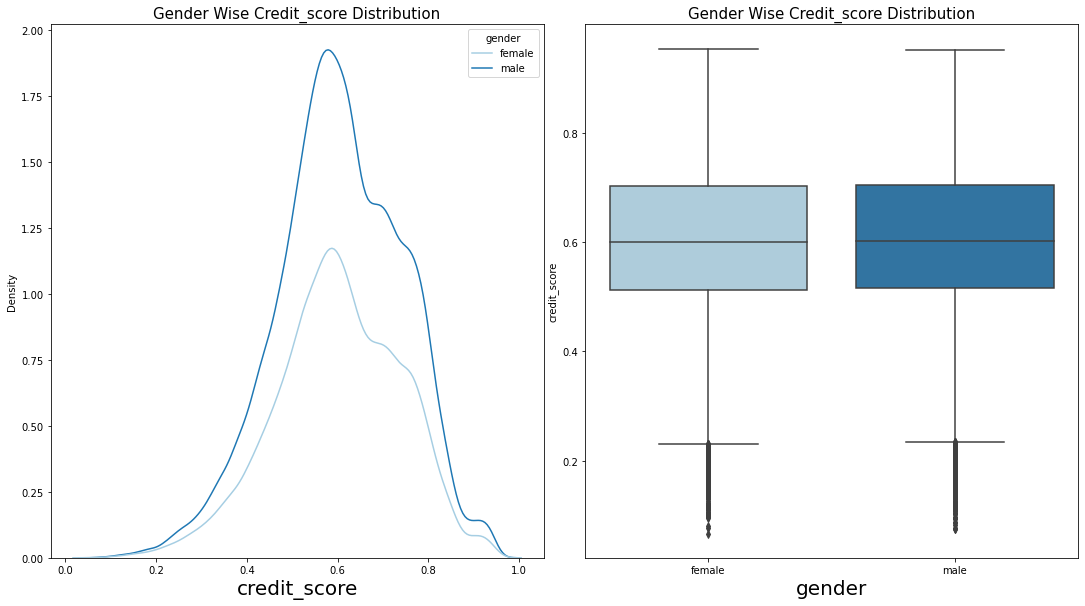

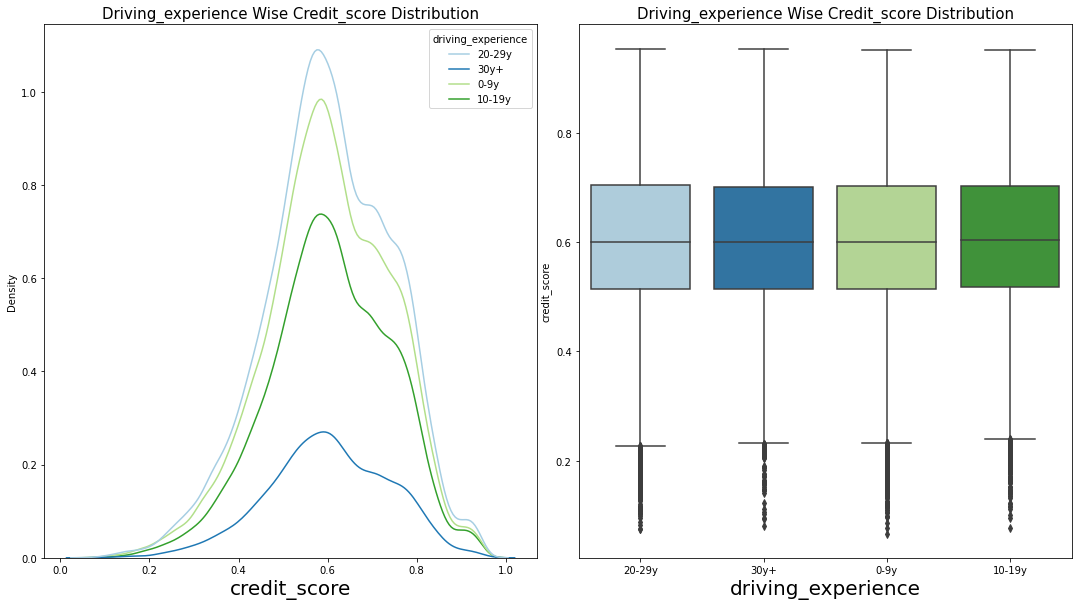

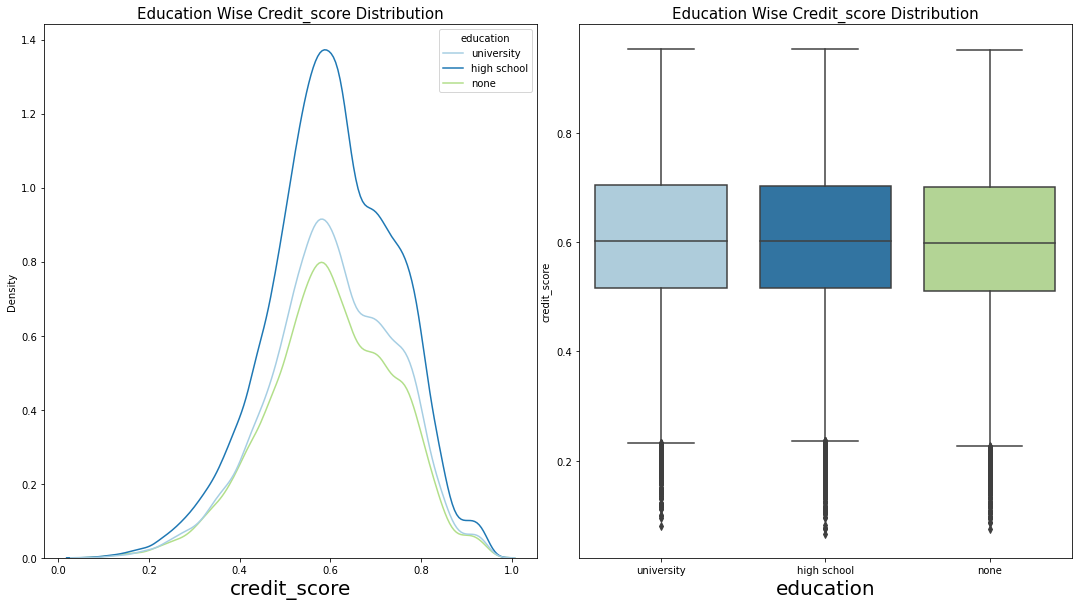

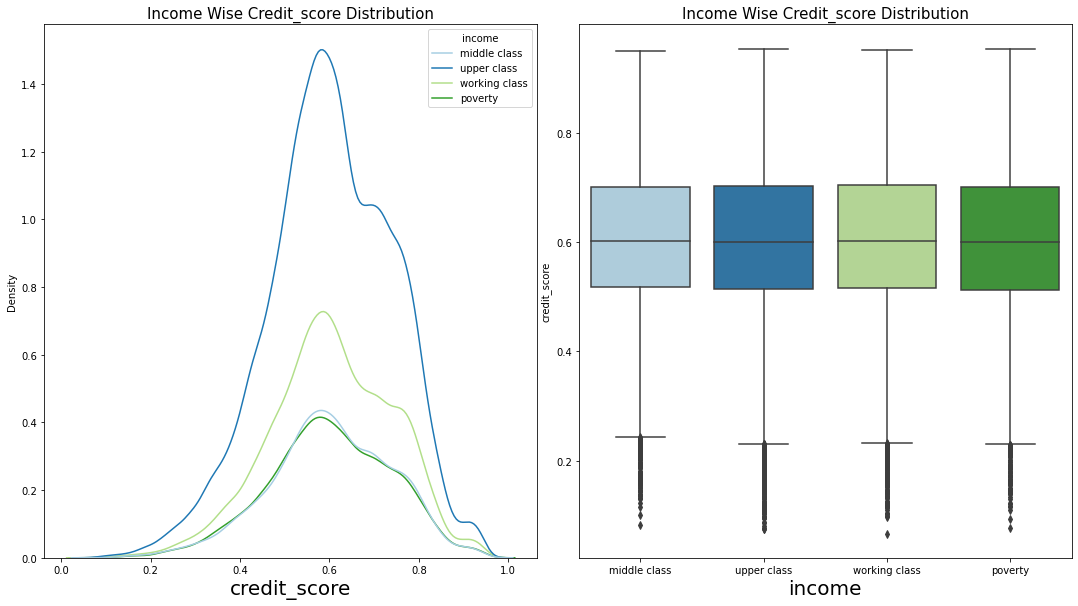

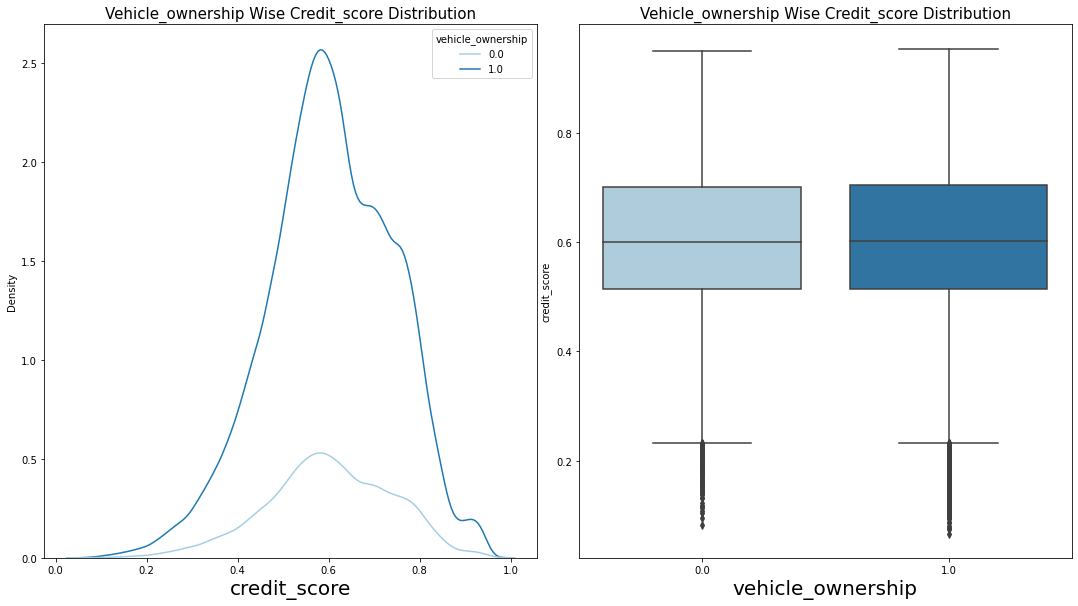

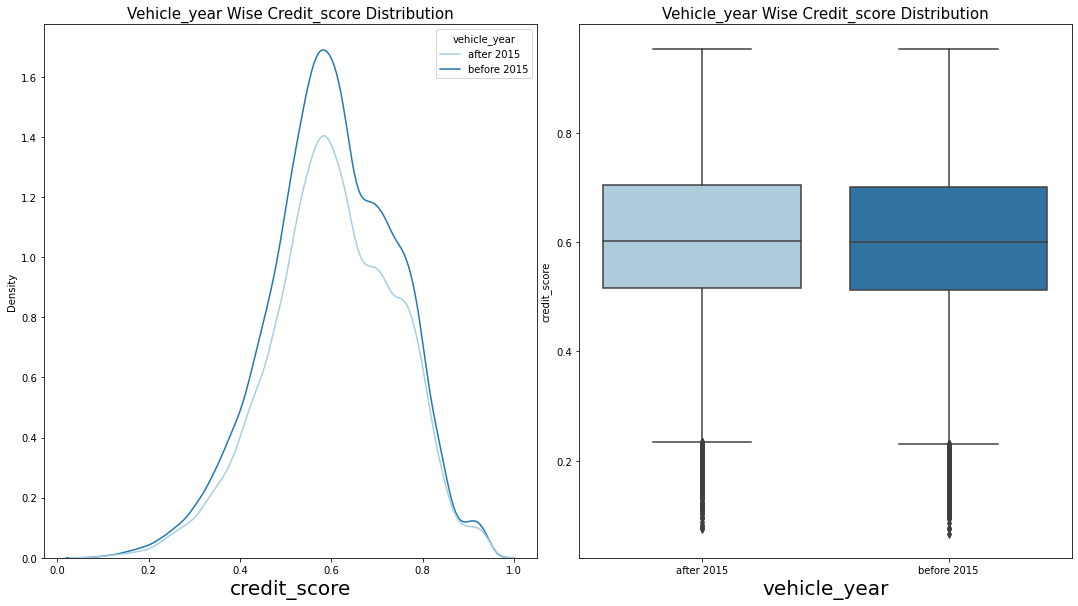

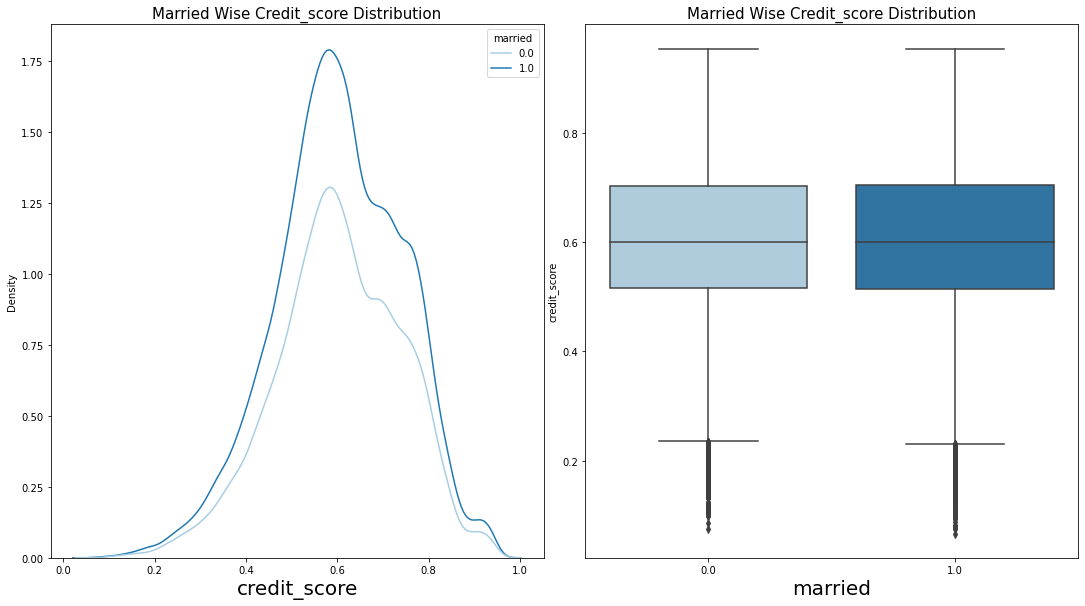

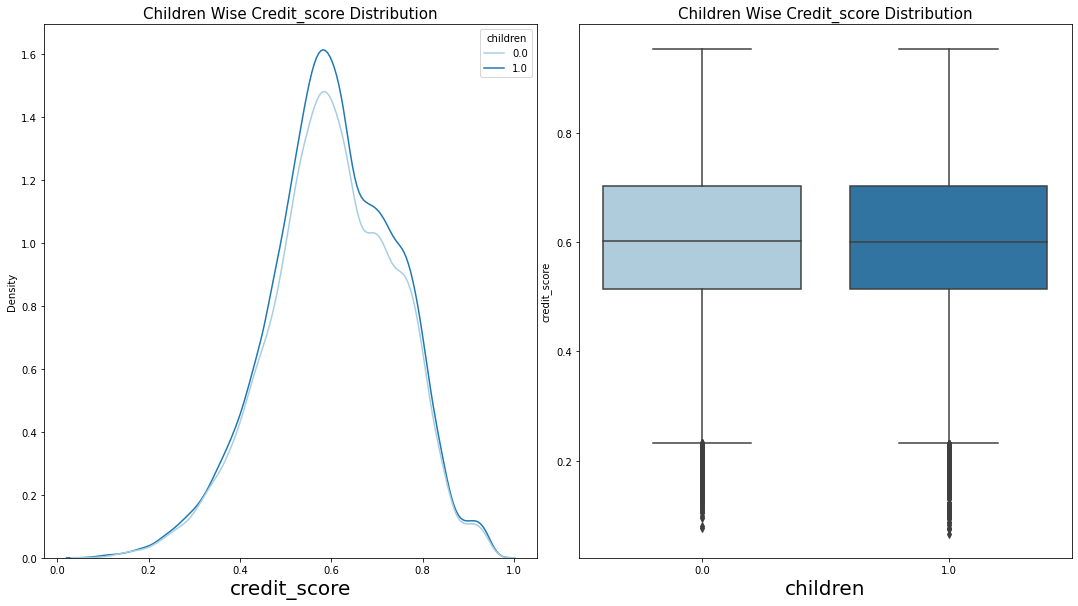

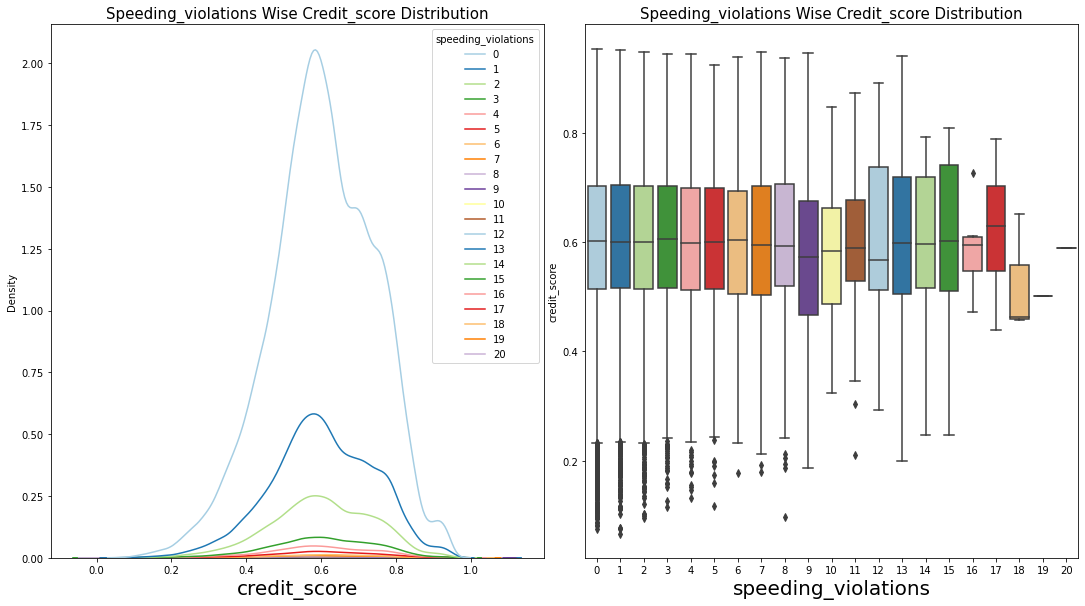

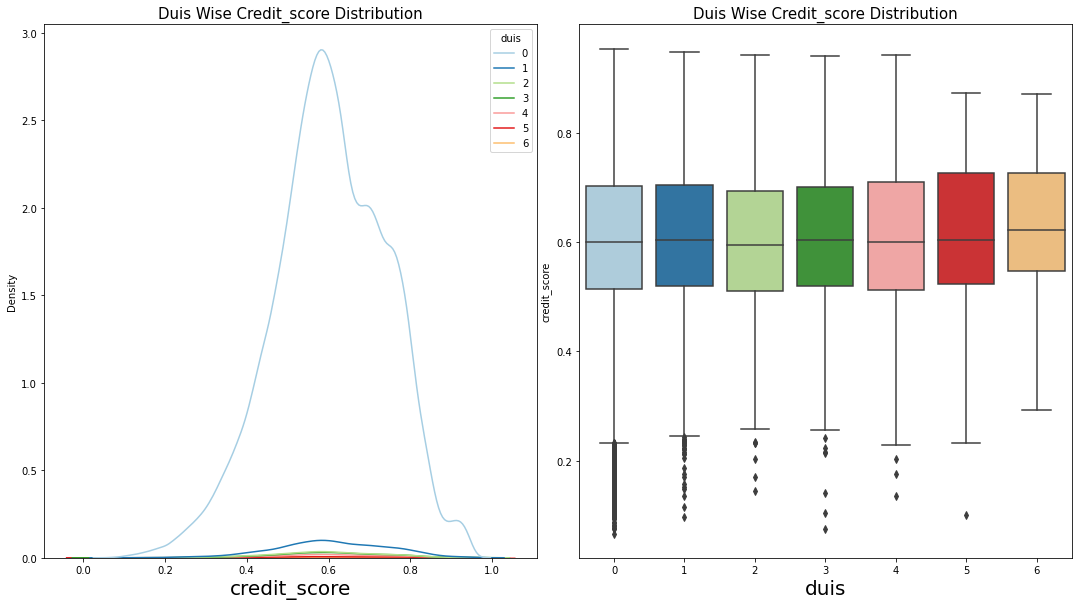

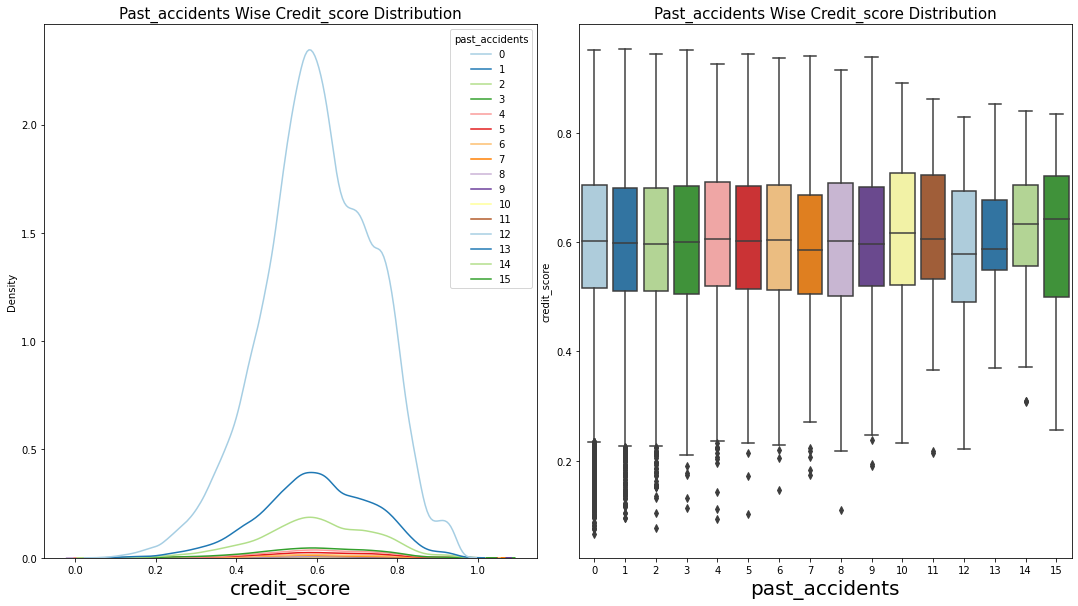

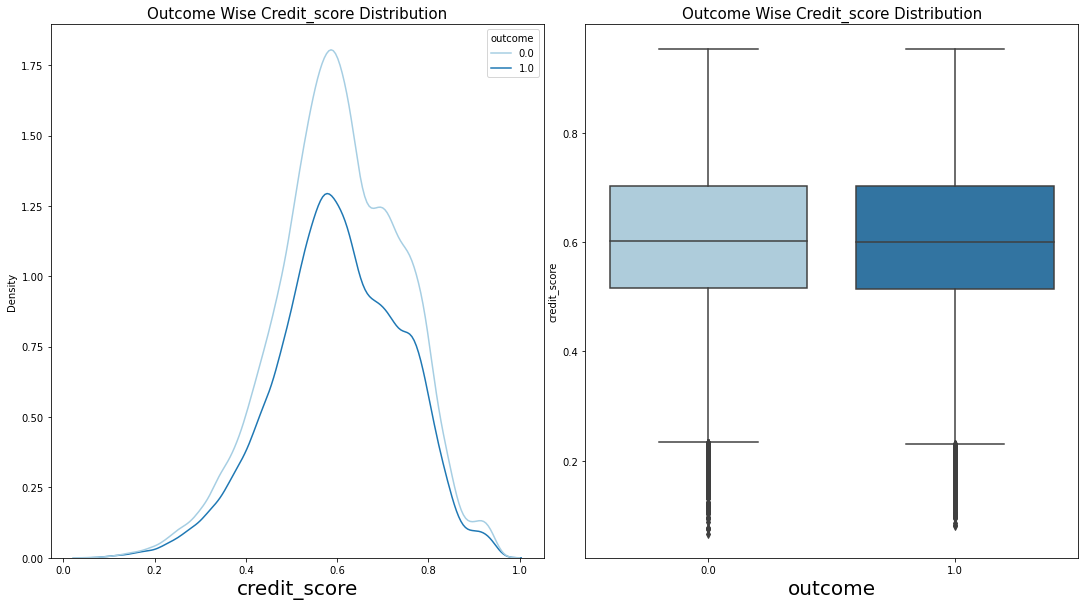

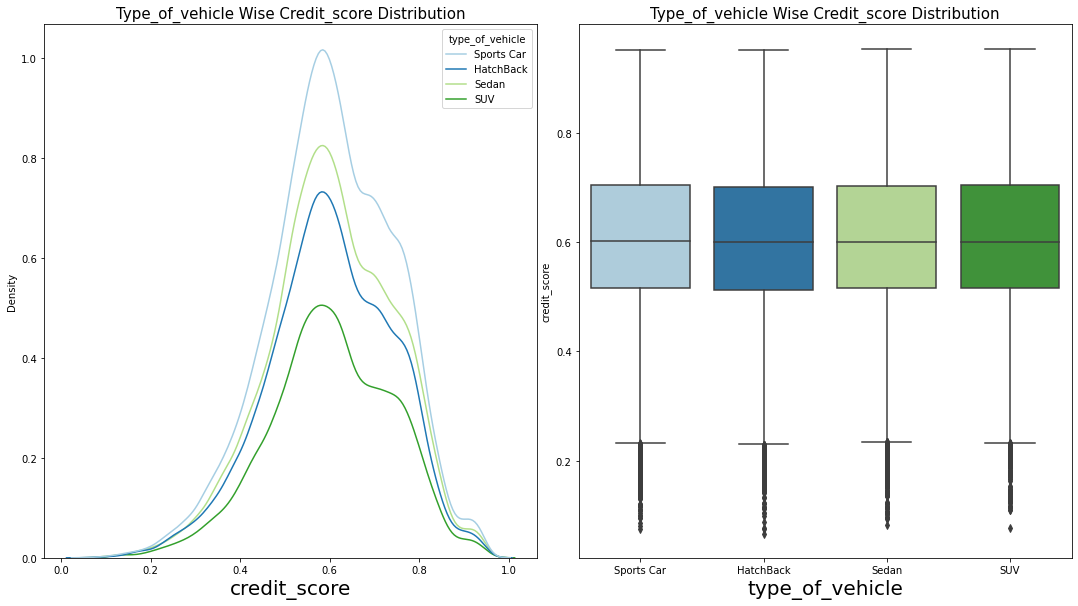

In [25]:
fig=plt.figure(figsize=(15,8))
for i,col  in enumerate(['age', 'gender', 'driving_experience', 'education', 'income',
                        'vehicle_ownership', 'vehicle_year', 'married',
                       'children', 'speeding_violations',
                       'duis', 'past_accidents', 'outcome', 'type_of_vehicle']): 
    _=side_by_side_plot(train,col,'credit_score')

### Let's see vehicle's annual mileaged istribution by different categorical columns age, gender, driving_experience, education, income, vehicle_ownership, vehicle_year, married, children, speeding_violations, duis, past_accidents, outcome, type_of_vehicle.

<Figure size 1080x576 with 0 Axes>

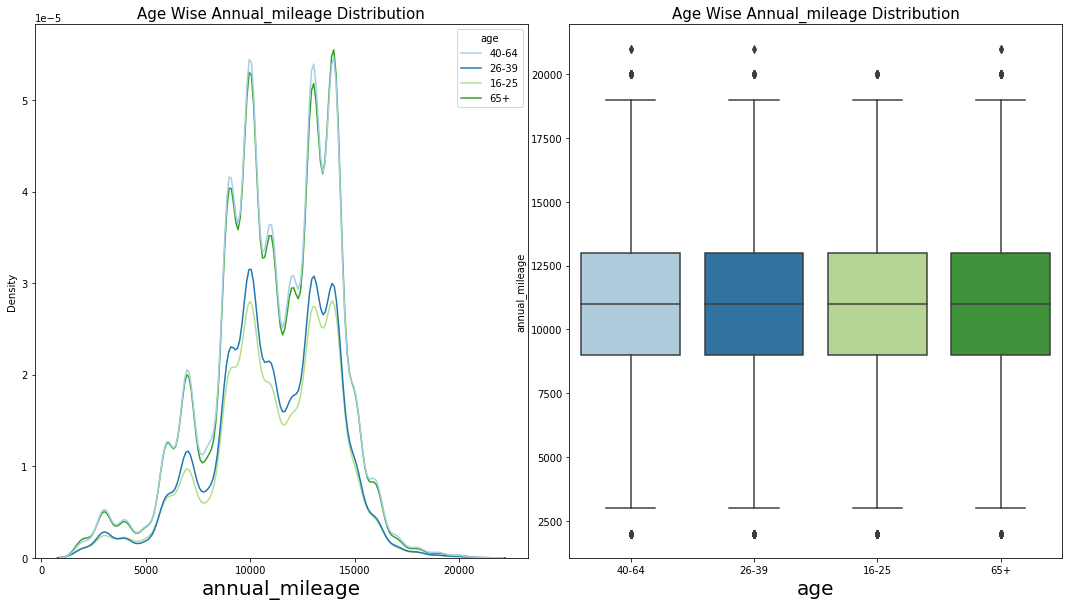

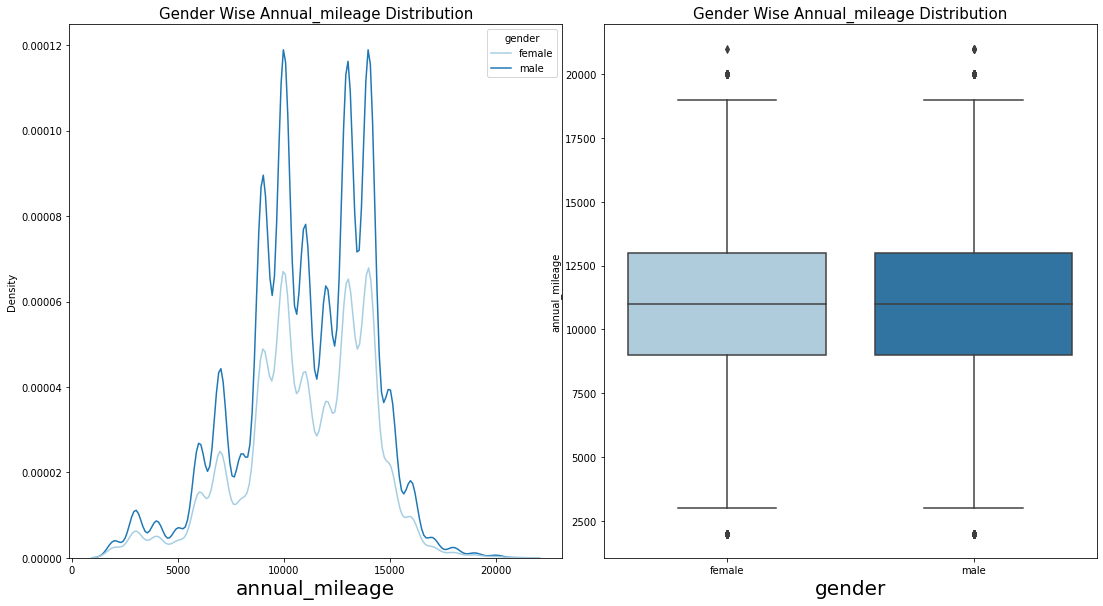

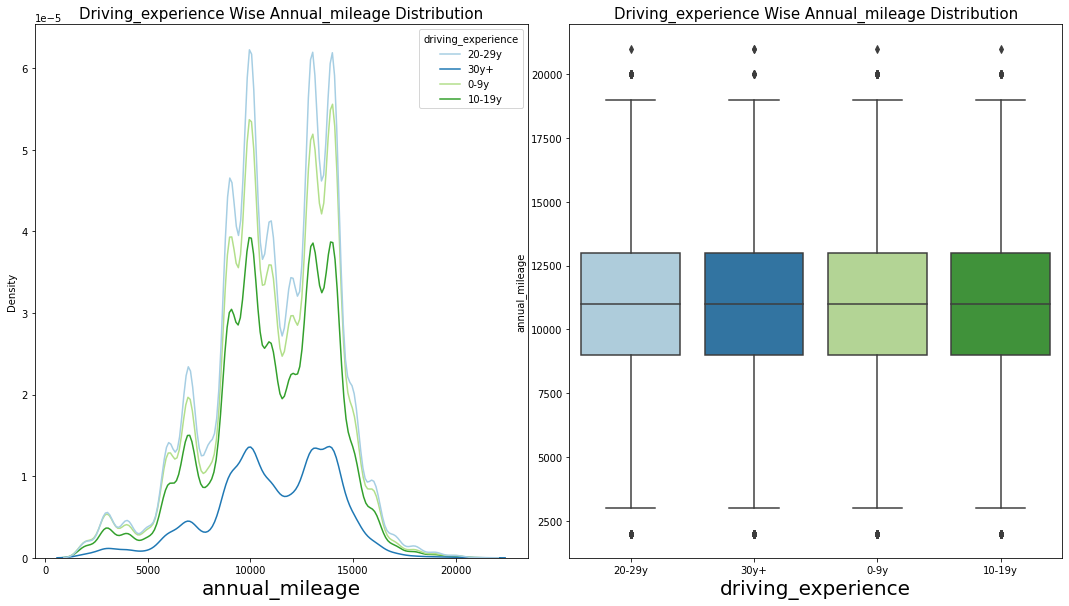

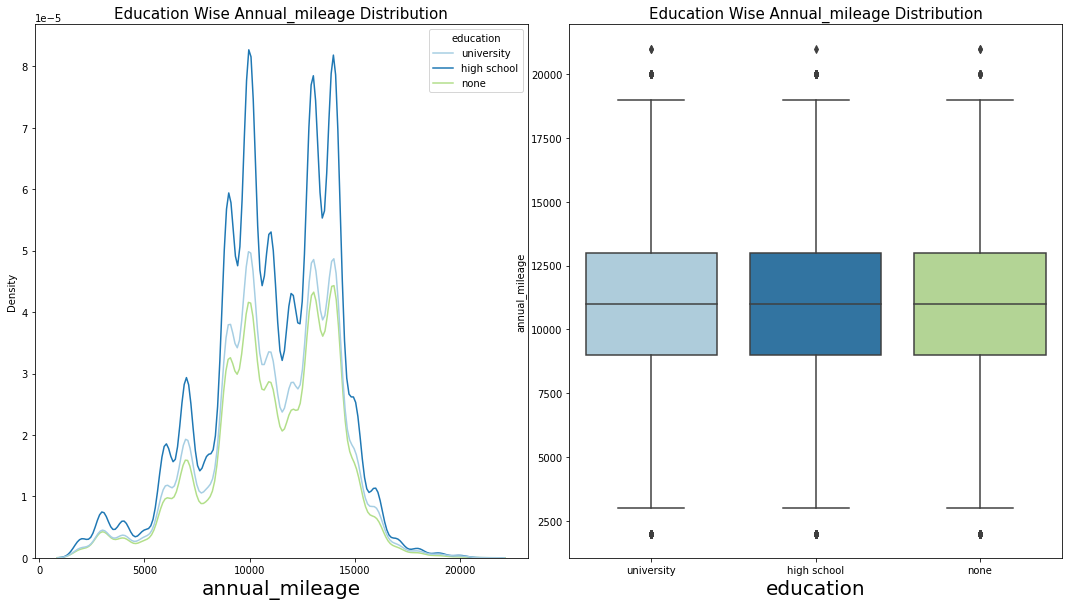

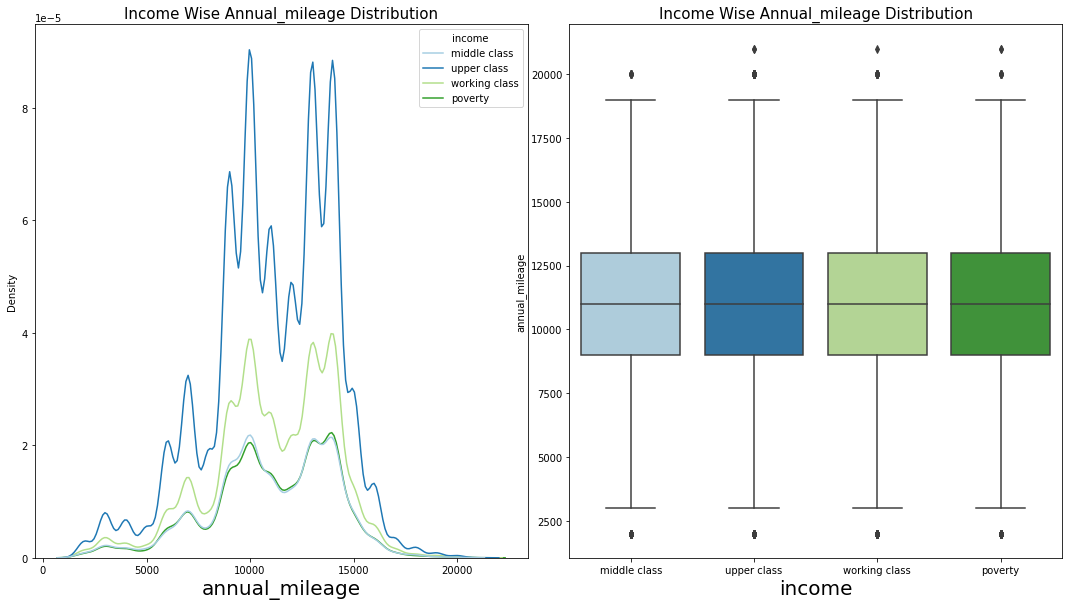

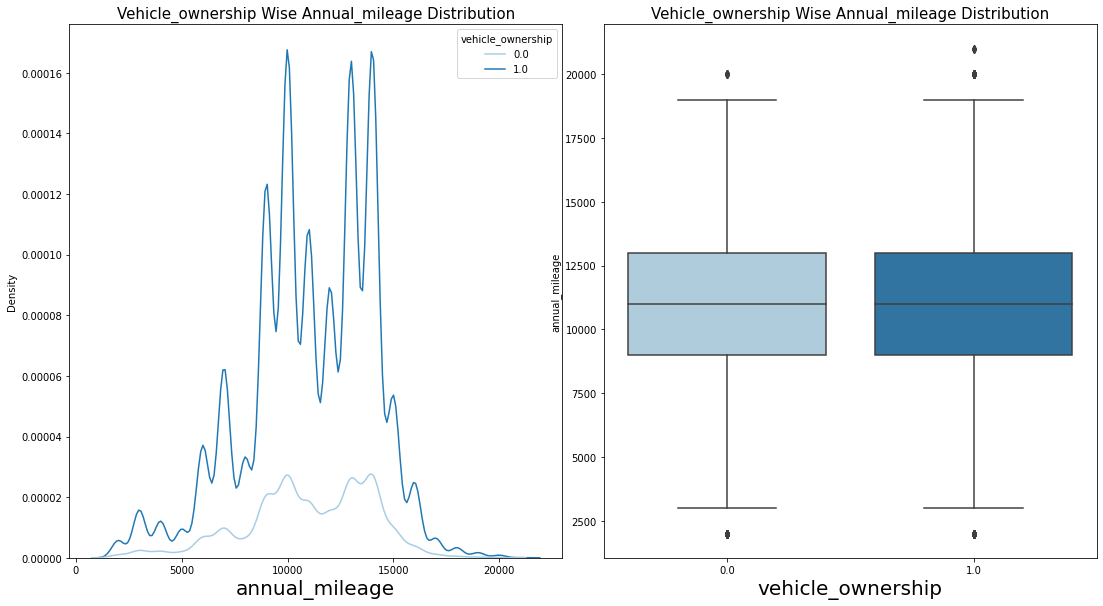

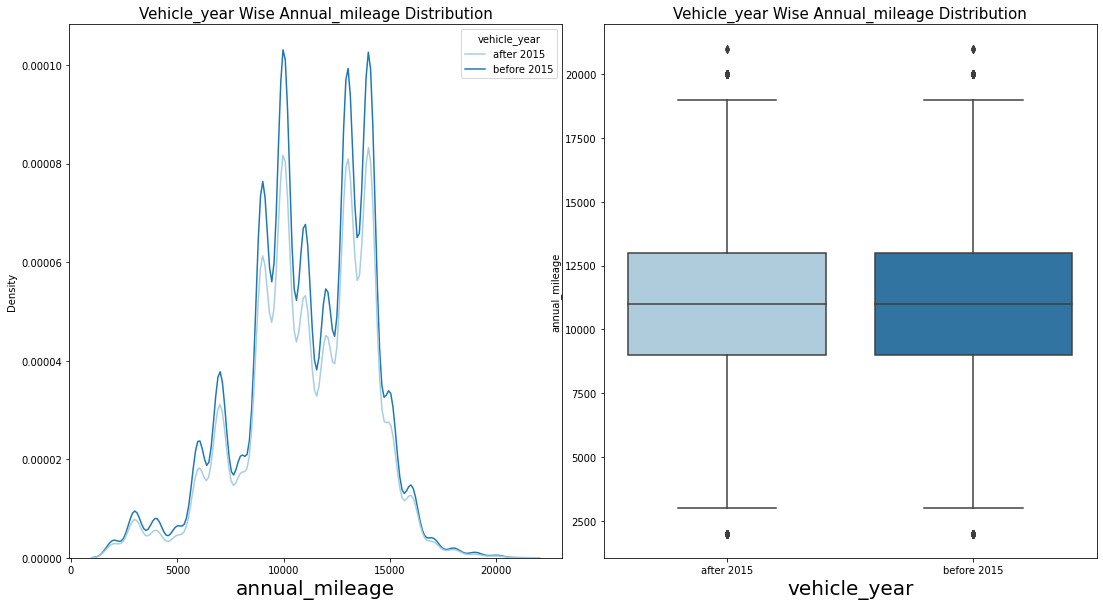

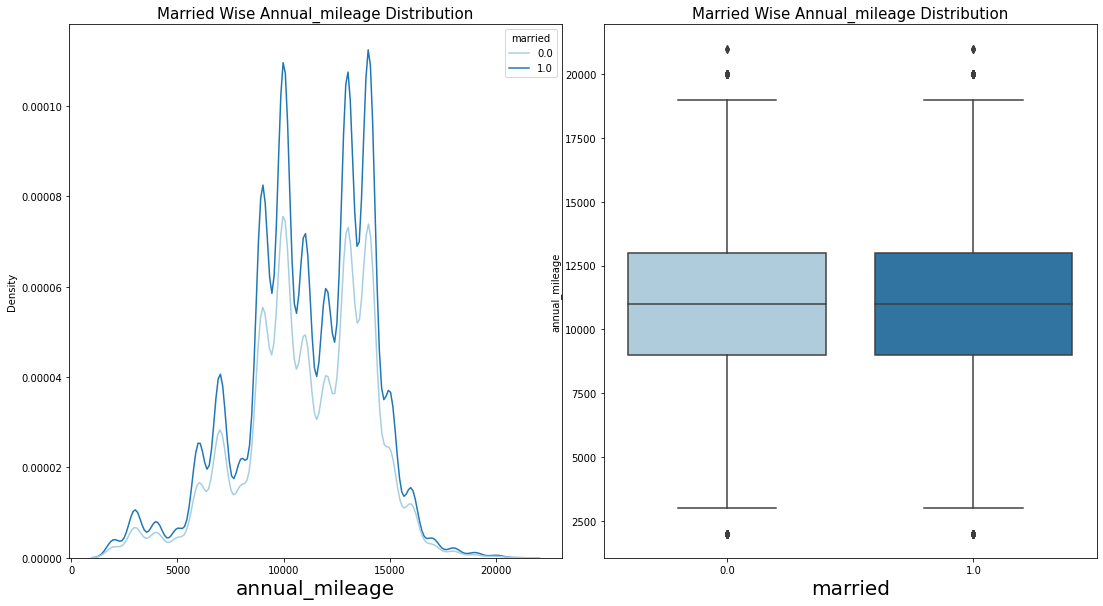

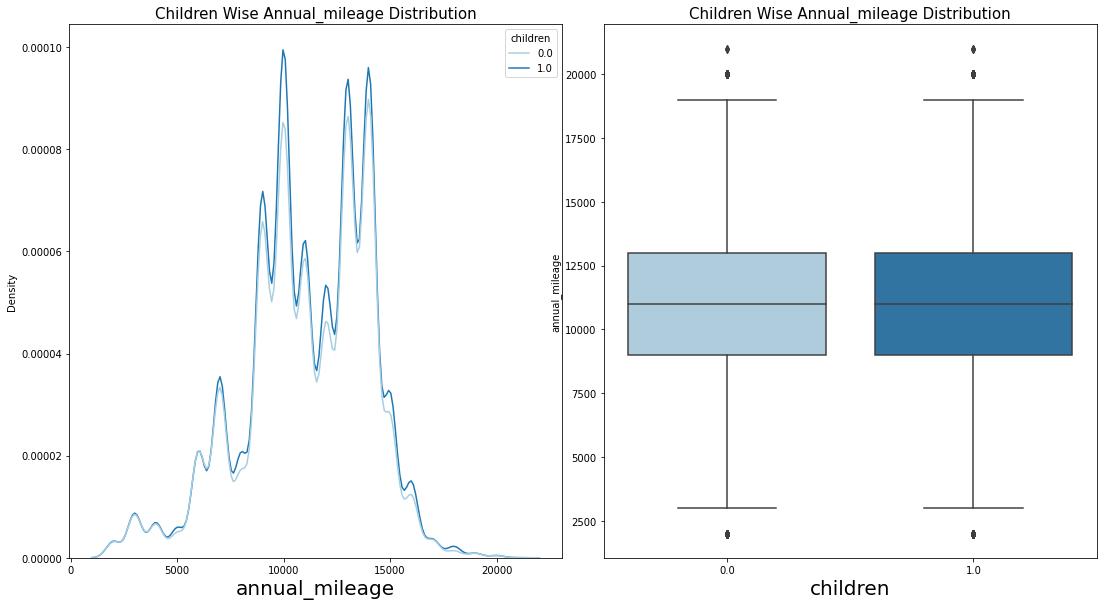

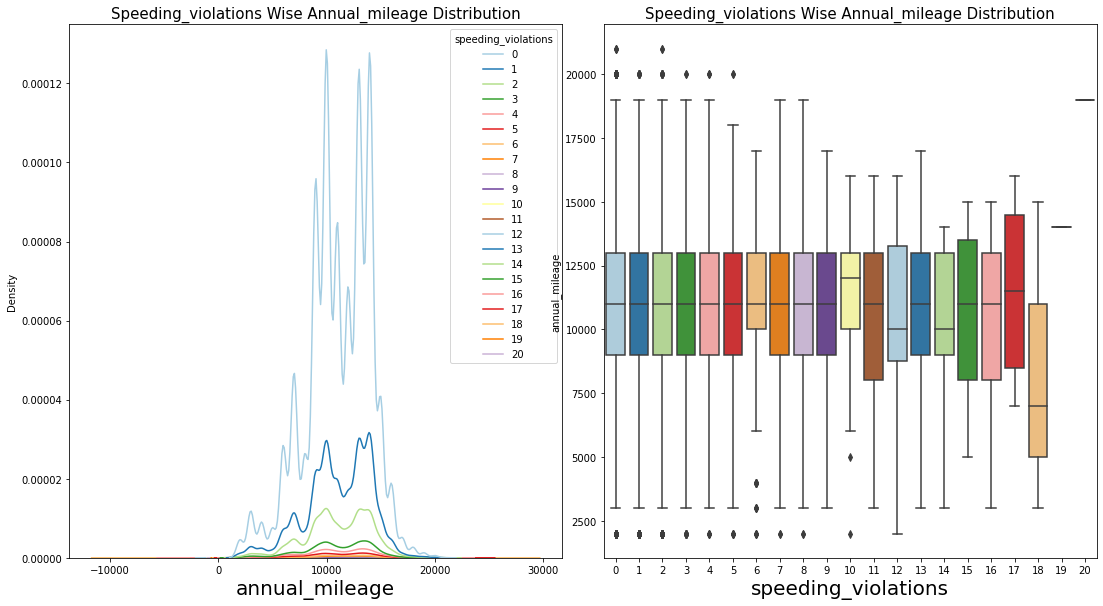

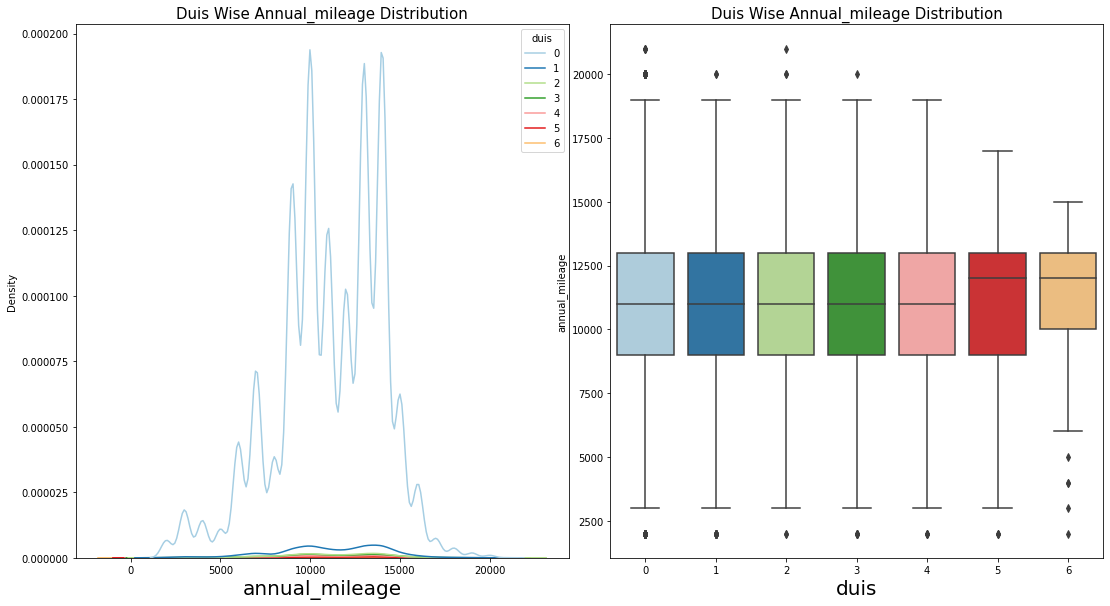

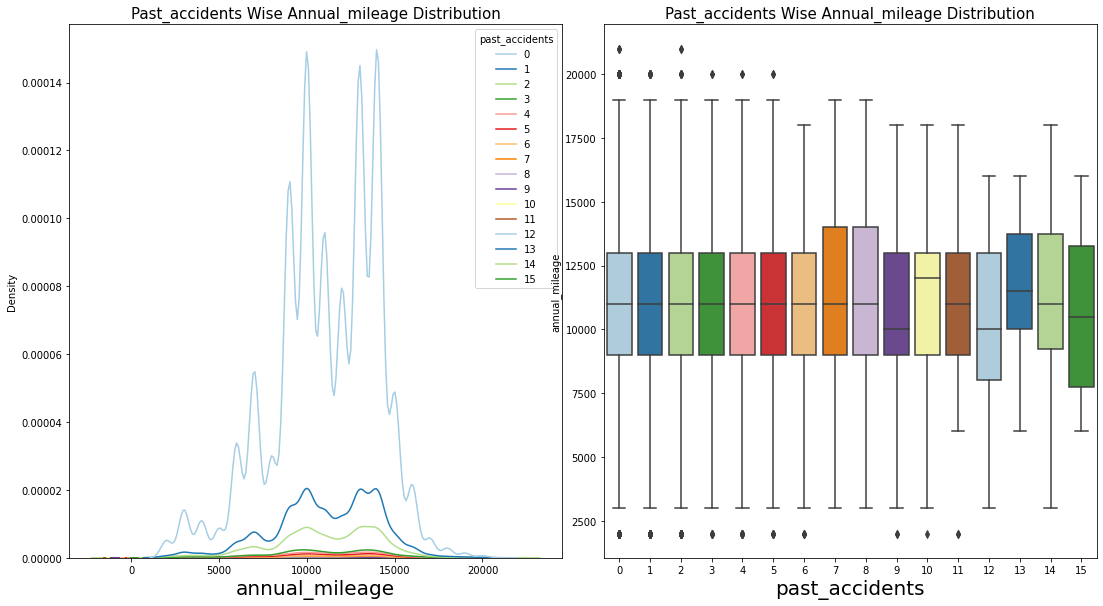

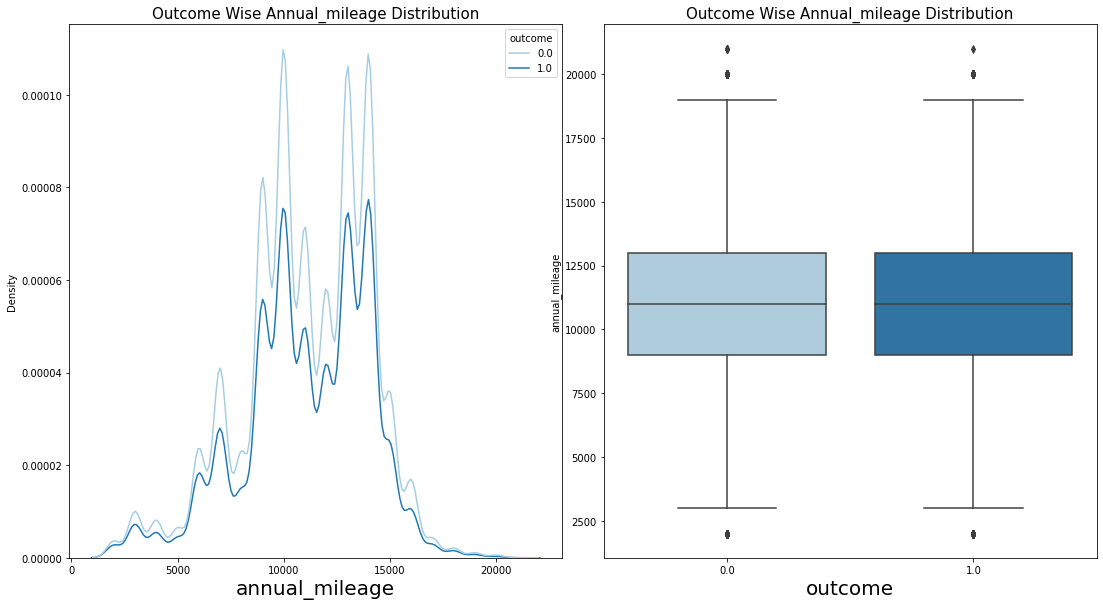

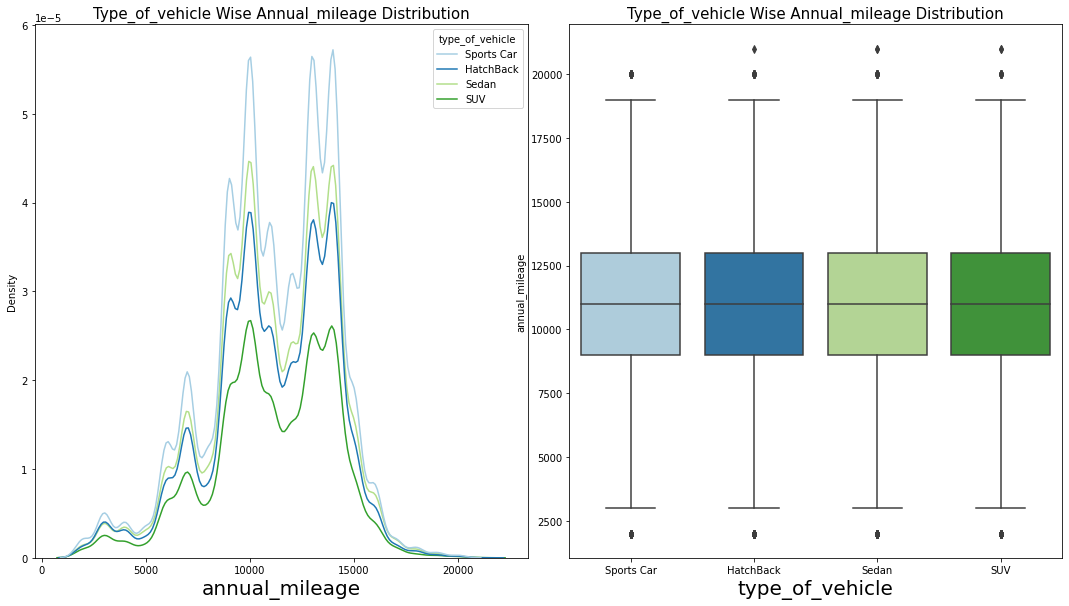

In [26]:
fig=plt.figure(figsize=(15,8))
for i,col  in enumerate(['age', 'gender', 'driving_experience', 'education', 'income',
                        'vehicle_ownership', 'vehicle_year', 'married',
                       'children', 'speeding_violations',
                       'duis', 'past_accidents', 'outcome', 'type_of_vehicle']): 
    _=side_by_side_plot(train,col,'annual_mileage')

In [25]:
kde_plot_summary = PrettyTable([i.capitalize() for i in['name','skew','kurtosis','mean','median','mean>median']])
kde_plot_summary.align['Name']="l"
for field in ['skew','kurtosis','mean','median']:
    kde_plot_summary.align[field]="r"
    


for num, col  in enumerate(['credit_score','annual_mileage']):
    d=list()
    d.append(f"{num+1}.{col.capitalize()}")

    d.append(round(skew(train[col], axis=0, bias=True),3))
    d.append(round(kurtosis(train[col], axis=0, bias=True),3))
    d.append(round(train[col].describe()[1],3))
    d.append(round(train[col].describe()[6],3))
    d.append(train[col].describe()[1]>train[col].describe()[6])
    kde_plot_summary.add_row(d)

kde_plot_summary

Name,Skew,Kurtosis,Mean,Median,Mean>median
1.Credit_score,-0.226,-0.041,0.602,0.703,False
2.Annual_mileage,-0.51,0.127,11061.229,13000.0,False


In [26]:
box_plot_summary = PrettyTable([i.capitalize() for i in['name', 'min', 'Q1-25%', 'Q2(Median)50%', 'Q3-75%', 'max','iqr','lower limit','upper limit','outlier']])
box_plot_summary.align["Name"] = "l"

for num, col  in enumerate(['credit_score','annual_mileage']):
    d=list()
    d.append(f"{num+1}.{col.capitalize()}")
    d.append(round(train[col].describe()[3],3))
    d.append(round(train[col].describe()[4],3))
    d.append(round(train[col].describe()[5],3))
    d.append(round(train[col].describe()[6],3))
    d.append(round(train[col].describe()[7],3))
    d.append(round(train[col].describe()[6]-train[col].describe()[4],3))
    low_limit=round(train[col].describe()[4]-1.5*(train[col].describe()[6]-train[col].describe()[4]),3)
    up_limit=round(train[col].describe()[6]+1.5*(train[col].describe()[6]-train[col].describe()[4]),3)
    d.append(low_limit)
    d.append(low_limit)
    d.append(any([(any(i < low_limit for i in train[col].values)), (any(i > up_limit for i in train[col].values))]))
    
    box_plot_summary.add_row(d)

box_plot_summary

Name,Min,Q1-25%,Q2(median)50%,Q3-75%,Max,Iqr,Lower limit,Upper limit,Outlier
1.Credit_score,0.067,0.515,0.601,0.703,0.954,0.188,0.232,0.232,True
2.Annual_mileage,2000.0,9000.0,11000.0,13000.0,21000.0,4000.0,3000.0,3000.0,True
